In [152]:
from configobj import ConfigObj
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.interpolate import RegularGridInterpolator
import pyccl as ccl
from pyDOE2 import *
import matplotlib

#from HiCOLA import Frontend

In [153]:
def wr_funct(T_CMB):
    return 4.48150052e-7*T_CMB**4 *(1+ 3.044*7/8 * (4/11)**(4/3))

T_CMB = 2.72548 # K
print(wr_funct(T_CMB))

"""Define tracker functions"""

# If we are on the tracker, we will get the following constraints equations

# For today formalism 
def k_1T(Omg_m, Omg_r, f_phi):
    return 6*f_phi*(Omg_m + Omg_r - 1)

# dS formalism

def E_dS(Omg_m, Omg_r, f_phi):

    return np.sqrt((1-f_phi)*(1-Omg_m-Omg_r)/2 + np.sqrt(
        ((1-f_phi)*(1-Omg_m-Omg_r)/2)**2 + f_phi*(1-Omg_m-Omg_r)
    ))

4.182345109176885e-05


In [154]:
print(E_dS(sample_new[0], wr_funct(T_CMB)/sample_new[3]**2, 0.42105263157894735))

0.8758833962962125


In [155]:
# dimensionless hubble parameter in GR
def E_LCDM_calc(Omg_r,Omg_m, a):
    return np.sqrt(Omg_m/a**3 +Omg_r/a**4 + (1 - Omg_m - Omg_r))

In [156]:
def T_CMB_funct(wr):
    return (wr/4.48150052e-7/(1+ 3.044*7/8 * (4/11)**(4/3)))**0.25

print(T_CMB_funct(4.28e-5))

2.7412520861203693


In [20]:
''' Define useful functions'''

def create_params(f, E, h, omegas):
    '''
    Get parameters k, g from f, E and cosmo
    Inputs:
    f --> fphi
    E --> EdS
    omegas --> [b, c, r] * h^2
    
    Outputs:
    k --> k1dS
    g --> g31dS
    '''
    
    # cosmological constant density
    o_DE = h**2 - omegas[0] - omegas[1] - omegas[2]
    O_L = (1-f)*o_DE/ h**2
    
    # k and g
    alpha = 1 - O_L/E**2
    k = -6*alpha
    g = 2*alpha
    
    return k, g

print(create_params(0.42105263157894735, 1/1.4032496307237814, 0.7307, [0.02196, 0.1274, 4.28e-5]))

(-1.0739300261094205, 0.3579766753698068)


In [271]:
# We want Omega_m , n_s , A_s ,h,  f_phi, EdS, k_1dS, g_31dS, wr, wb
sample_test = np.array([(0.1274 + 0.02196)/0.7307**2, 0.9626, 2.092e-9,0.7307,0.42105263157894735,1/1.4032496307237814,-0.34384601713152496,-8.289986166458684, 4.28e-5, 0.02196])
print(sample_test)

print("k_2dS test = ",k_2dS_funct(sample_test[4],sample_test[6], sample_test[7],sample_test[5], sample_test[0],4.28e-5/sample_test[3]**2))
print("g_32dS test = ",g_32dS_funct(sample_test[4],sample_test[6], sample_test[7], sample_test[5],sample_test[0],4.28e-5/sample_test[3]**2))

print("k_2dS paper = ", -1.460168017955791)
print("g_32dS paper = ",4.445662089077228)
print("f_phi paper = ", 0.42105263157894735)
print("E_dS paper = ", 1/1.4032496307237814)

k1_dS_new = -0.34384601713152496
g_31_dS_new = -8.289986166458684

sample_new = np.array([0.31966, 0.9626, 2.092e-9,0.6688, 0.3675555555555555,1/1.4032496307237814,k1_dS_new,g_31_dS_new, wr_funct(T_CMB), 0.022383])

k_2_dS_new = k_2dS_funct(sample_new[4],sample_new[6], sample_new[7],sample_test[5], sample_new[0],wr_funct(T_CMB)/sample_new[3]**2)
g_32_dS_new = g_32dS_funct(sample_new[4],sample_new[6], sample_new[7],sample_test[5], sample_new[0],wr_funct(T_CMB)/sample_new[3]**2)

print("k_2dS = ",k_2_dS_new)
print("g_32dS = ",g_32_dS_new)




[ 2.79740979e-01  9.62600000e-01  2.09200000e-09  7.30700000e-01
  4.21052632e-01  7.12631579e-01 -3.43846017e-01 -8.28998617e+00
  4.28000000e-05  2.19600000e-02]
k_2dS test =  -1.460168017955791
g_32dS test =  4.445662089077228
k_2dS paper =  -1.460168017955791
g_32dS paper =  4.445662089077228
f_phi paper =  0.42105263157894735
E_dS paper =  0.7126315789473684
k_2dS =  -1.1465488407358295
g_32dS =  4.393392226207235


In [272]:
## Power spectrum from CCL - backscaling

wr = sample_new[-2]

ns = sample_new[1]
As = sample_new[2]
h = sample_new[3]
wm = sample_new[0]*h**2
wb = sample_new[-1]

kk_ccl = np.logspace(-3,1,500)*h               # in 1/Mpc
cosmoLCDM = ccl.Cosmology(Omega_c=(wm - wb)/h**2,
                           Omega_b=wb/h**2, 
                           A_s=As, 
                           h = h,
                           n_s=ns,
                           Omega_k=0)

# Omega_g::: Note that if a non-None value is given, this may result in a physically 
# inconsistent model because the CMB temperature will still be non-zero in the parameters.
cosmoLCDM_norad = ccl.Cosmology(Omega_c=(wm - wb)/h**2,
                           Omega_b=wb/h**2, 
                           A_s=As, 
                           h = h,
                           n_s=ns,
                           Omega_k=0,
                           Omega_g = 0,
                           T_CMB = 0.0)

Pk_0 = ccl.power.linear_matter_power(cosmoLCDM, kk_ccl, 1)    # in (Mpc)^3

Growth_0 = ccl.background.growth_factor(cosmoLCDM_norad, 1)

Growth_49 = ccl.background.growth_factor(cosmoLCDM_norad, 1/(1+49))

Pk_ccl = (Growth_49/Growth_0)**2 * Pk_0*h**3    # in (Mpc)^3/h^3

kk_ccl = kk_ccl/h    # in h/Mpc
## Save power spectrum for initial conditions (Linear)

np.savetxt("/home/c2042999/PCA_project/HiCOLA_files/P_k_z.dat", np.array([kk_ccl, Pk_ccl]).T)



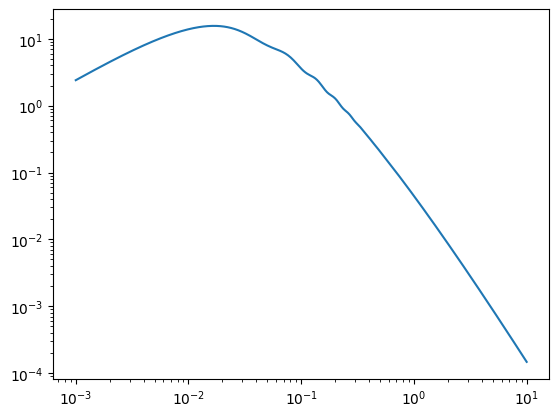

In [273]:
## Plot power spectra (at z = 49, expect very different from z=0)

plt.plot(kk_ccl,Pk_ccl)

plt.xscale("log")
plt.yscale("log")

## Get expansion and force files

In [274]:
''' Define useful functions'''

def Update_ini(run, sample, num_ini, horn_ini):
    """
    Updates file num_ini to include the parameters (numerical)
    """
    h = sample[3]
    wr = sample[-2]
    wb =  sample[-1]
    wc = sample[0]*h**2 - wb
    
    config_n = ConfigObj(num_ini)
    config_h = ConfigObj(horn_ini)
    keys_n = config_n.keys()
    keys_h = config_h.keys()

    k_2_dS_new = k_2dS_funct(sample[4],sample[6], sample[7],sample[5], sample[0],wr/sample[3]**2)
    g_32_dS_new = g_32dS_funct(sample[4],sample[6], sample[7],sample[5], sample[0],wr/sample[3]**2)

    ### Horndeski
    config_h[keys_h[1]] = '/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output'
    config_h[keys_h[0]] = str(run)
    
    config_h[keys_h[2]] = 'k_1*X + k_2*X*X'
    config_h[keys_h[3]] = 'g_31*X + g_32*X*X'
    config_h[keys_h[4]] = '0.5'

    config_h[keys_h[9]] = str(sample[6])
    config_h[keys_h[10]] = str(k_2_dS_new)
    config_h[keys_h[11]] = str(sample[7])
    config_h[keys_h[12]] = str(g_32_dS_new)
    
    config_h[keys_h[13]] = str(sample[4])
    config_h[keys_h[14]] = str(1/sample[5])
    
    ### Numerical
    
    config_n[keys_n[0]] = 'run_'+str(run)
    
    config_n[keys_n[6]] = str(h)
    config_n[keys_n[7]] = str(wr)
    config_n[keys_n[8]] = str(wb)
    config_n[keys_n[9]] = str(wc)
    config_n.filename = '/home/c2042999/PCA_project/HiCOLA_files/numerical.ini'
    config_h.filename = '/home/c2042999/PCA_project/HiCOLA_files/horndeski_ESS.ini'
    config_n.write()
    config_h.write()

In [275]:
Update_ini("ESS", sample_new, '/home/c2042999/HiCOLA_env/Cubic_galileon_emu/numerical_parameters.ini', '/home/c2042999/PCA_project/HiCOLA_files/horndeski_ESS-C.ini')


In [276]:

command = 'cd ; cd /home/c2042999/HiCOLA_env/Hi-COLA; python3 -m HiCOLA.Frontend.generate_simulation_input /home/c2042999/PCA_project/HiCOLA_files/horndeski_ESS.ini /home/c2042999/PCA_project/HiCOLA_files/numerical.ini'
#command = 'cd ; cd /home/c2042999/HiCOLA_env/Hi-COLA; python3 -m HiCOLA.Frontend.generate_simulation_input /home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/Parameter_files/Frontend_parameter_files/examples/ESS/ESS-C.ini /home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/Parameter_files/Frontend_parameter_files/examples/WMAP_cosmological_parameters.ini'

os.system(command)


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/PCA_project/HiCOLA_files/horndeski_ESS.ini', '/home/c2042999/PCA_project/HiCOLA_files/numerical.ini'])
Horndeski functions --------------
K = X**2*k_2 + X*k_1
G_3 = X**2*g_32 + X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
ESS model parameters, [k_1, k_2, g_31, g_32] = [-0.34384601713152496, -1.1465488407358295, -8.289986166458684, 4.393392226207235]
Cosmological parameters-----------
Omega_m0 = 0.31966
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.4302181176364394
Initial conditions----------------
Hubble0 = 1.4032496307237814
scalar_prime0 = 0.9
Closure parameter is phiprime = 1.004674731472211
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output


0

Text(0, 0.5, 'CuGal coupling $(\\beta)$')

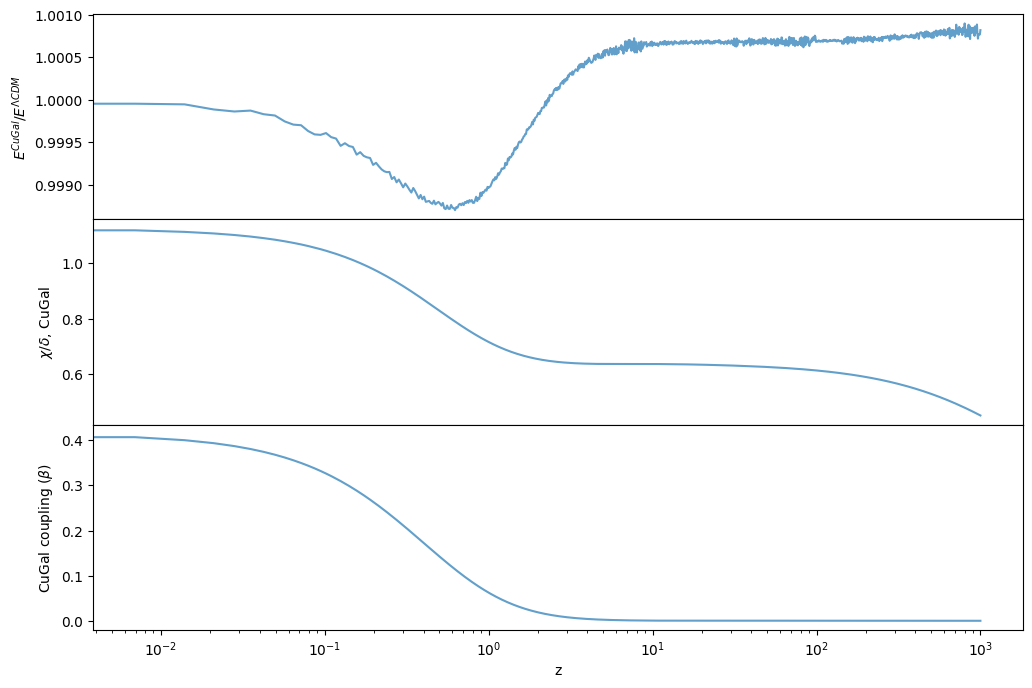

In [278]:
## Plotting ##

fig, ax = plt.subplots(3,1, figsize=(12,8),sharex=True)
fig.subplots_adjust(hspace=0,wspace=0)

# We want Omega_m*h^2 , n_s    , A_s ,h,  f_phi
expansion_today = np.loadtxt("/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output/ESS_run_ESS_expansion.txt")

wr = sample_new[-2]
h = sample_new[3]
wm = sample_new[0]*h**2

a_today = expansion_today.T[0]
E_a_today = expansion_today.T[1]
E_a_GR = np.sqrt((wm)*a_today**(-3) + wr*a_today**(-4) + (h**2 - (wm) -wr))/h

ax[0].plot(1/a_today -1, E_a_today/E_a_GR, alpha=0.7)
#ax[0].plot(1/a_today -1, E_a_GR, alpha=0.7)

force_today = np.loadtxt("/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output/ESS_run_ESS_force.txt")

a_today = force_today.T[0]
chiD_today = force_today.T[1] # chi/delta
coupling = force_today.T[2]

ax[1].plot(1/a_today -1, chiD_today, alpha=0.7)

ax[2].semilogx(1/a_today -1, coupling, alpha=0.7)
#ax[2].semilogx(1/a_today -1, 0.6/E_LCDM_calc(wr/h**2,sample_new[0], a_today)**2, alpha=0.7)

ax[0].set_xscale("log")
ax[2].set_xlabel("z")
ax[0].set_ylabel(r"$E^{CuGal}/E^{\Lambda CDM}$")

ax[1].set_ylabel(r"$\chi/\delta$, CuGal")
ax[2].set_ylabel(r"CuGal coupling $(\beta)$")


## Find best param combination (only need to do once)

In [249]:
s_len = 10
f_phi_arange = np.linspace(0.366, 0.3679, s_len)

In [270]:
print(f_phi_arange[7])

0.3675555555555555


In [251]:
sample_new = np.array([np.ones(s_len)*0.31966, np.ones(s_len)*0.9626, np.ones(s_len)*2.092e-9,np.ones(s_len)*0.6688, f_phi_arange,np.ones(s_len)/1.4032496307237814,np.ones(s_len)*k1_dS_new,np.ones(s_len)*g_31_dS_new, np.ones(s_len)*wr_funct(T_CMB), np.ones(s_len)*0.022383])


In [252]:
for i in range(s_len):
    Update_ini("ESS"+str(i), sample_new.T[i], '/home/c2042999/HiCOLA_env/Cubic_galileon_emu/numerical_parameters.ini', '/home/c2042999/PCA_project/HiCOLA_files/horndeski_ESS-C.ini')
    command = 'cd ; cd /home/c2042999/HiCOLA_env/Hi-COLA; python3 -m HiCOLA.Frontend.generate_simulation_input /home/c2042999/PCA_project/HiCOLA_files/horndeski_ESS.ini /home/c2042999/PCA_project/HiCOLA_files/numerical.ini'
    #start = time.time()
    os.system(command)


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/PCA_project/HiCOLA_files/horndeski_ESS.ini', '/home/c2042999/PCA_project/HiCOLA_files/numerical.ini'])
Horndeski functions --------------
K = X**2*k_2 + X*k_1
G_3 = X**2*g_32 + X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
ESS0 model parameters, [k_1, k_2, g_31, g_32] = [-0.34384601713152496, -1.1215452167460174, -8.289986166458684, 4.389224955542266]
Cosmological parameters-----------
Omega_m0 = 0.31966
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.43127627885339476
Initial conditions----------------
Hubble0 = 1.4032496307237814
scalar_prime0 = 0.9
Closure parameter is phiprime = 1.0047589420433185
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/PCA_project/HiCOLA_files/horndeski_ESS.ini', '/home/c2042999/PCA_project/HiCOLA_files/numerical.ini'])
Horndeski functions --------------
K = X**2*k_2 + X*k_1
G_3 = X**2*g_32 + X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
ESS1 model parameters, [k_1, k_2, g_31, g_32] = [-0.34384601713152496, -1.1251171630302759, -8.289986166458684, 4.389820279922976]
Cosmological parameters-----------
Omega_m0 = 0.31966
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.4311251129652583
Initial conditions----------------
Hubble0 = 1.4032496307237814
scalar_prime0 = 0.9
Closure parameter is phiprime = 1.004746905383911
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/PCA_project/HiCOLA_files/horndeski_ESS.ini', '/home/c2042999/PCA_project/HiCOLA_files/numerical.ini'])
Horndeski functions --------------
K = X**2*k_2 + X*k_1
G_3 = X**2*g_32 + X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
ESS2 model parameters, [k_1, k_2, g_31, g_32] = [-0.34384601713152496, -1.1286891093145357, -8.289986166458684, 4.390415604303685]
Cosmological parameters-----------
Omega_m0 = 0.31966
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.4309739470771218
Initial conditions----------------
Hubble0 = 1.4032496307237814
scalar_prime0 = 0.9
Closure parameter is phiprime = 1.0047348709181088
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/PCA_project/HiCOLA_files/horndeski_ESS.ini', '/home/c2042999/PCA_project/HiCOLA_files/numerical.ini'])
Horndeski functions --------------
K = X**2*k_2 + X*k_1
G_3 = X**2*g_32 + X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
ESS3 model parameters, [k_1, k_2, g_31, g_32] = [-0.34384601713152496, -1.1322610555987942, -8.289986166458684, 4.391010928684395]
Cosmological parameters-----------
Omega_m0 = 0.31966
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.4308227811889853
Initial conditions----------------
Hubble0 = 1.4032496307237814
scalar_prime0 = 0.9
Closure parameter is phiprime = 1.0047228386453122
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/PCA_project/HiCOLA_files/horndeski_ESS.ini', '/home/c2042999/PCA_project/HiCOLA_files/numerical.ini'])
Horndeski functions --------------
K = X**2*k_2 + X*k_1
G_3 = X**2*g_32 + X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
ESS4 model parameters, [k_1, k_2, g_31, g_32] = [-0.34384601713152496, -1.1358330018830527, -8.289986166458684, 4.391606253065104]
Cosmological parameters-----------
Omega_m0 = 0.31966
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.43067161530084885
Initial conditions----------------
Hubble0 = 1.4032496307237814
scalar_prime0 = 0.9
Closure parameter is phiprime = 1.0047108085649228
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/PCA_project/HiCOLA_files/horndeski_ESS.ini', '/home/c2042999/PCA_project/HiCOLA_files/numerical.ini'])
Horndeski functions --------------
K = X**2*k_2 + X*k_1
G_3 = X**2*g_32 + X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
ESS5 model parameters, [k_1, k_2, g_31, g_32] = [-0.34384601713152496, -1.1394049481673125, -8.289986166458684, 4.392201577445815]
Cosmological parameters-----------
Omega_m0 = 0.31966
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.43052044941271234
Initial conditions----------------
Hubble0 = 1.4032496307237814
scalar_prime0 = 0.9
Closure parameter is phiprime = 1.0046987806763417
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/PCA_project/HiCOLA_files/horndeski_ESS.ini', '/home/c2042999/PCA_project/HiCOLA_files/numerical.ini'])
Horndeski functions --------------
K = X**2*k_2 + X*k_1
G_3 = X**2*g_32 + X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
ESS6 model parameters, [k_1, k_2, g_31, g_32] = [-0.34384601713152496, -1.142976894451571, -8.289986166458684, 4.392796901826525]
Cosmological parameters-----------
Omega_m0 = 0.31966
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.4303692835245759
Initial conditions----------------
Hubble0 = 1.4032496307237814
scalar_prime0 = 0.9
Closure parameter is phiprime = 1.0046867549789706
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/PCA_project/HiCOLA_files/horndeski_ESS.ini', '/home/c2042999/PCA_project/HiCOLA_files/numerical.ini'])
Horndeski functions --------------
K = X**2*k_2 + X*k_1
G_3 = X**2*g_32 + X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
ESS7 model parameters, [k_1, k_2, g_31, g_32] = [-0.34384601713152496, -1.1465488407358295, -8.289986166458684, 4.393392226207235]
Cosmological parameters-----------
Omega_m0 = 0.31966
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.4302181176364394
Initial conditions----------------
Hubble0 = 1.4032496307237814
scalar_prime0 = 0.9
Closure parameter is phiprime = 1.004674731472211
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/PCA_project/HiCOLA_files/horndeski_ESS.ini', '/home/c2042999/PCA_project/HiCOLA_files/numerical.ini'])
Horndeski functions --------------
K = X**2*k_2 + X*k_1
G_3 = X**2*g_32 + X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
ESS8 model parameters, [k_1, k_2, g_31, g_32] = [-0.34384601713152496, -1.1501207870200894, -8.289986166458684, 4.393987550587944]
Cosmological parameters-----------
Omega_m0 = 0.31966
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.4300669517483029
Initial conditions----------------
Hubble0 = 1.4032496307237814
scalar_prime0 = 0.9
Closure parameter is phiprime = 1.0046627101554657
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


Namespace(input_ini_filenames=['/home/c2042999/PCA_project/HiCOLA_files/horndeski_ESS.ini', '/home/c2042999/PCA_project/HiCOLA_files/numerical.ini'])
Horndeski functions --------------
K = X**2*k_2 + X*k_1
G_3 = X**2*g_32 + X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
ESS9 model parameters, [k_1, k_2, g_31, g_32] = [-0.34384601713152496, -1.1536927333043465, -8.289986166458684, 4.394582874968654]
Cosmological parameters-----------
Omega_m0 = 0.31966
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.42991578586016643
Initial conditions----------------
Hubble0 = 1.4032496307237814
scalar_prime0 = 0.9


Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/Frontend/generate_simulation_input.py", line 89, in <module>
    background_quantities = ns.run_solver(read_out_dict)
  File "/home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/Frontend/numerical_solver.py", line 266, in run_solver
    ans = solve_ivp(comp_primes,[x_final,x_ini], Y0, t_eval=x_arr_inv, method='RK45', args=(Hubble0, Omega_r0, Omega_m0, Omega_l0, E_prime_E_lambda, E_prime_E_safelambda, phi_primeprime_lambda, phi_primeprime_safelambda, A_lambda, cl_declaration, parameters,threshold,GR_flag), rtol = 1e-14)#, hmax=hmaxv)
  File "/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/scipy/integrate/_ivp/ivp.py", line 591, in solve_ivp
    message = solver.step()
  File "/home/c2042999/PCA_env/3

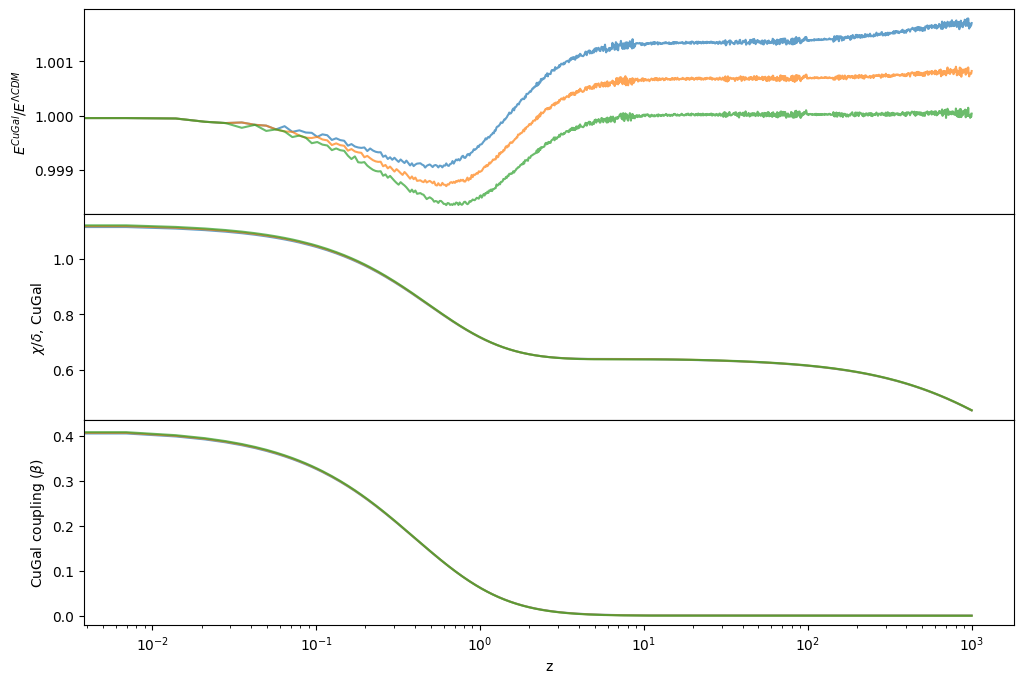

In [261]:
## Plotting ##

fig, ax = plt.subplots(3,1, figsize=(12,8),sharex=True)
fig.subplots_adjust(hspace=0,wspace=0)
for i in range(3):
    i=6+i
    # We want Omega_m*h^2 , n_s    , A_s ,h,  f_phi
    expansion_today = np.loadtxt("/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output/ESS{}_run_ESS{}_expansion.txt".format(i,i))
    
    wr = sample_new.T[i][-2]
    h = sample_new.T[i][3]
    wm = sample_new.T[i][0]*h**2
    
    a_today = expansion_today.T[0]
    E_a_today = expansion_today.T[1]
    E_a_GR = np.sqrt((wm)*a_today**(-3) + wr*a_today**(-4) + (h**2 - (wm) -wr))/h
    
    ax[0].plot(1/a_today -1, E_a_today/E_a_GR, alpha=0.7)
    #ax[0].plot(1/a_today -1, E_a_GR, alpha=0.7)
    
    force_today = np.loadtxt("/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output/ESS{}_run_ESS{}_force.txt".format(i,i))
    
    a_today = force_today.T[0]
    chiD_today = force_today.T[1] # chi/delta
    coupling = force_today.T[2]
    
    ax[1].plot(1/a_today -1, chiD_today, alpha=0.7)
    
    ax[2].semilogx(1/a_today -1, coupling, alpha=0.7)
    #ax[2].semilogx(1/a_today -1, 0.6/E_LCDM_calc(wr/h**2,sample_new[0], a_today)**2, alpha=0.7)
    
    ax[0].set_xscale("log")
    ax[2].set_xlabel("z")
    ax[0].set_ylabel(r"$E^{CuGal}/E^{\Lambda CDM}$")
    
    ax[1].set_ylabel(r"$\chi/\delta$, CuGal")
    ax[2].set_ylabel(r"CuGal coupling $(\beta)$")


## Rewrite Lua file

In [284]:
def rewriteluafile(k, sample,boxsize,n_particles,n_mesh):
    
    #sample = Omega_m , n_s , A_s ,h,  f_phi, EdS, k_1dS, g_31dS, k_2dS, g_32dS, wr, wb

    wb = sample[-1]
    wr = sample[-2]
    n_s = sample[1]
    A_s = sample[2]
    h = sample[3]
    wm = sample[0]*h**2

    f_phi = sample[4]
    
    # Derived params
    Omg_r = wr/h**2
    Omg_m = wm/h**2
    Omg_b = wb/h**2
    Omg_Lambda = (1-f_phi)*(1-Omg_m-Omg_r)
    Omg_DE = (1-Omg_m-Omg_r)
    
    a= open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Hi-COLA_params_emu.lua','r')
    b = a.readlines()
    c = open('/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_params_ESS-C_{}.lua'.format(str(k)),'w')
    for i in range(len(b)):
        if i==19:
            c.write('simulation_name = "my_new_Hi-COLA_simulation_ESS-C_{}"'.format(str(k))+'\n')
        elif i==21:
            c.write('simulation_boxsize = '+str(boxsize)+'\n')
        elif i== 40:
            c.write('cosmology_OmegaCDM = '+str((wm-wb)/h**2)+'\n')
        elif i== 42:
            c.write('cosmology_Omegab = '+str(wb/h**2)+'\n')
        elif i== 46:
            c.write('cosmology_OmegaLambda = '+str(Omg_DE)+'\n')
        elif i== 50:
            c.write('cosmology_TCMB_kelvin = '+str(T_CMB_funct(wr))+'\n')
        elif i== 52:
            c.write('cosmology_h = '+str(h)+'\n')
        elif i== 54:
            c.write('cosmology_As = '+str(A_s)+'\n')
        elif i== 56:
            c.write('cosmology_ns = '+str(n_s)+'\n')
        elif i== 63:
            c.write('  HiCOLA_expansion_filename = "/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output/ESS_run_ESS_expansion.txt"'+'\n')
        elif i== 100:
            c.write('  HiCOLA_preforce_filename = "/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output/ESS_run_ESS_force.txt"'+'\n')
        elif i== 208:
            c.write('particle_Npart_1D = '+str(n_particles)+'\n')
        elif i== 210:
            c.write('particle_allocation_factor = '+str(2.0)+'\n')
        elif i== 222:
            c.write('output_folder = "/home/c2042999/PCA_project/HiCOLA_files/Output_backend/COLA_{}"'.format(str(k))+'\n')
        elif i== 229:
            c.write('timestep_nsteps = {50}'+'\n')  
        elif i== 247:
            c.write('ic_random_seed ='+str(100+k)+'\n')
        elif i== 251:
            c.write('ic_fix_amplitude = true'+'\n')
        elif i== 253:
            c.write('ic_reverse_phases = false'+'\n') 
        elif i== 269:
            c.write('ic_input_filename = "/home/c2042999/PCA_project/HiCOLA_files/P_k_z.dat"'+'\n')
        elif i== 271:
            c.write('ic_input_redshift = 49.0'+'\n')
        elif i== 312:
            c.write('force_nmesh = '+str(n_mesh)+'\n')
        elif i== 345:
            c.write('pofk_nmesh = '+str(n_mesh)+'\n')
        #elif i== 359:
        #    c.write('pofk_multipole_nmesh = '+str(n_mesh)+'\n')
        #elif i== 375:
        #    c.write('bispectrum_nmesh = '+str(n_mesh)+'\n')
        else:
            c.write(b[i])

    c.close()
    a.close()


In [285]:
def rewriteluafile_phasepair(k, sample,boxsize,n_particles,n_mesh):

    #sample = Omega_m , n_s , A_s ,h,  f_phi, EdS, k_1dS, g_31dS, k_2dS, g_32dS, wr, wb

    wb = sample[-1]
    wr = sample[-2]
    n_s = sample[1]
    A_s = sample[2]
    h = sample[3]
    wm = sample[0]*h**2

    f_phi = sample[4]
    
    # Derived params
    Omg_r = wr/h**2
    Omg_m = wm/h**2
    Omg_b = wb/h**2
    Omg_Lambda = (1-f_phi)*(1-Omg_m-Omg_r)
    Omg_DE = (1-Omg_m-Omg_r)
    
    a= open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Hi-COLA_params_emu.lua','r')
    b = a.readlines()
    c = open('/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_params_ESS-C_phasepair_{}.lua'.format(str(k)),'w')
    for i in range(len(b)):
        if i==19:
            c.write('simulation_name = "my_new_Hi-COLA_simulation_ESS-C_phasepair_{}"'.format(str(k))+'\n')
        elif i==21:
            c.write('simulation_boxsize = '+str(boxsize)+'\n')
        elif i== 40:
            c.write('cosmology_OmegaCDM = '+str((wm-wb)/h**2)+'\n')
        elif i== 42:
            c.write('cosmology_Omegab = '+str(wb/h**2)+'\n')
        elif i== 46:
            c.write('cosmology_OmegaLambda = '+str(Omg_DE)+'\n')
        elif i== 50:
            c.write('cosmology_TCMB_kelvin = '+str(T_CMB_funct(wr))+'\n')
        elif i== 52:
            c.write('cosmology_h = '+str(h)+'\n')
        elif i== 54:
            c.write('cosmology_As = '+str(A_s)+'\n')
        elif i== 56:
            c.write('cosmology_ns = '+str(n_s)+'\n')
        elif i== 63:
            c.write('  HiCOLA_expansion_filename = "/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output/ESS_run_ESS_expansion.txt"'+'\n')
        elif i== 100:
            c.write('  HiCOLA_preforce_filename = "/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_Output/ESS_run_ESS_force.txt"'+'\n')
        elif i== 208:
            c.write('particle_Npart_1D = '+str(n_particles)+'\n')
        elif i== 210:
            c.write('particle_allocation_factor = '+str(2.0)+'\n')
        elif i== 222:
            c.write('output_folder = "/home/c2042999/PCA_project/HiCOLA_files/Output_backend/COLA_{}"'.format(str(k))+'\n')
        elif i== 229:
            c.write('timestep_nsteps = {50}'+'\n')  
        elif i== 247:
            c.write('ic_random_seed ='+str(100+k)+'\n')
        elif i== 251:
            c.write('ic_fix_amplitude = true'+'\n')
        elif i== 253:
            c.write('ic_reverse_phases = true'+'\n') 
        elif i== 269:
            c.write('ic_input_filename = "/home/c2042999/PCA_project/HiCOLA_files/P_k_z.dat"'+'\n')
        elif i== 271:
            c.write('ic_input_redshift = 49.0'+'\n')
        elif i== 312:
            c.write('force_nmesh = '+str(n_mesh)+'\n')
        elif i== 345:
            c.write('pofk_nmesh = '+str(n_mesh)+'\n')
        #elif i== 359:
        #    c.write('pofk_multipole_nmesh = '+str(n_mesh)+'\n')
        #elif i== 375:
        #    c.write('bispectrum_nmesh = '+str(n_mesh)+'\n')
        else:
            c.write(b[i])

    c.close()
    a.close()


In [286]:
## Create lua files

rewriteluafile(8,sample_new,400,512,1536)
# phase pair
rewriteluafile_phasepair(8,sample_new,400,512,1536)

In [287]:
"""Create P(k)"""

os.system("cd; cd /home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/FML/COLASolver; mpirun -np 32 nbody /home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_params_ESS-C_8.lua")



#=====================================================
#           ________________  .____         
#           \_   _____/     \ |    |      
#            |    __)/  \ /  \|    |      
#            |     \/    Y    \    |___   
#            \___  /\____|__  /_______ \ 
#                \/         \/        \/ 
#
# Initializing FML, MPI and FFTW
# MPI is enabled. Running with 32 MPI tasks
# OpenMP is enabled. Main task has 80 threads availiable
# MPI + Threads is working
# FFTW is enabled. Thread support is enabled
#
# List of tasks:
# Task    0 [pulsar-cn-4]
#     x-domain [       0 ,  0.03125)
# Task    1 [pulsar-cn-4]
#     x-domain [ 0.03125 ,   0.0625)
# Task    2 [pulsar-cn-4]
#     x-domain [  0.0625 ,  0.09375)
# Task    3 [pulsar-cn-4]
#     x-domain [ 0.09375 ,    0.125)
# Task    4 [pulsar-cn-4]
#     x-domain [   0.125 ,  0.15625)
# Task    5 [pulsar-cn-4]
#     x-domain [ 0.15625 ,   0.1875)
# Task    6 [pulsar-cn-4]
#     x-domain [  0.1875 ,  0.21875)
# Task    7 [pulsa

0

In [288]:
"""Create P(k) phasepair"""

os.system("cd; cd /home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/FML/COLASolver; mpirun -np 32 nbody /home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_params_ESS-C_phasepair_8.lua")



#=====================================================
#           ________________  .____         
#           \_   _____/     \ |    |      
#            |    __)/  \ /  \|    |      
#            |     \/    Y    \    |___   
#            \___  /\____|__  /_______ \ 
#                \/         \/        \/ 
#
# Initializing FML, MPI and FFTW
# MPI is enabled. Running with 32 MPI tasks
# OpenMP is enabled. Main task has 80 threads availiable
# MPI + Threads is working
# FFTW is enabled. Thread support is enabled
#
# List of tasks:
# Task    0 [pulsar-cn-4]
#     x-domain [       0 ,  0.03125)
# Task    1 [pulsar-cn-4]
#     x-domain [ 0.03125 ,   0.0625)
# Task    2 [pulsar-cn-4]
#     x-domain [  0.0625 ,  0.09375)
# Task    3 [pulsar-cn-4]
#     x-domain [ 0.09375 ,    0.125)
# Task    4 [pulsar-cn-4]
#     x-domain [   0.125 ,  0.15625)
# Task    5 [pulsar-cn-4]
#     x-domain [ 0.15625 ,   0.1875)
# Task    6 [pulsar-cn-4]
#     x-domain [  0.1875 ,  0.21875)
# Task    7 [pulsa

0

In [289]:
def rewriteluafile_GR(k, sample,boxsize,n_particles,n_mesh):
    """
    Takes in txt file with (omega_m,n_s,A_s,E_ds,f_phi) for all k
    For a certain backend file number (a certain k) it creates a lua file that makes HiCOLA output in a separate folder
    """

    #sample = Omega_m , n_s , A_s ,h,  f_phi, EdS, k_1dS, g_31dS, k_2dS, g_32dS, wr, wb

    wb = sample[-1]
    wr = sample[-2]
    n_s = sample[1]
    A_s = sample[2]
    h = sample[3]
    wm = sample[0]*h**2

    f_phi = sample[4]
    
    # Derived params
    Omg_r = wr/h**2
    Omg_m = wm/h**2
    Omg_b = wb/h**2
    Omg_Lambda = (1-f_phi)*(1-Omg_m-Omg_r)
    Omg_DE = (1-Omg_m-Omg_r)
    
    a= open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Hi-COLA_params_emu.lua','r')
    b = a.readlines()
    c = open('/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_params_GR_{}.lua'.format(str(k)),'w')
    for i in range(len(b)):
        if i==19:
            c.write('simulation_name = "my_new_Hi-COLA_simulation_GR_{}"'.format(str(k))+'\n')
        elif i==21:
            c.write('simulation_boxsize = '+str(boxsize)+'\n')
        elif i==38:
            c.write('cosmology_model = "LCDM"'+'\n')
        elif i== 40:
            c.write('cosmology_OmegaCDM = '+str((wm-wb)/h**2)+'\n')
        elif i== 42:
            c.write('cosmology_Omegab = '+str(wb/h**2)+'\n')
        elif i== 46:
            c.write('cosmology_OmegaLambda = '+str(Omg_DE)+'\n')
        elif i== 50:
            c.write('cosmology_TCMB_kelvin = '+str(T_CMB)+'\n')
        elif i== 52:
            c.write('cosmology_h = '+str(h)+'\n')
        elif i== 54:
            c.write('cosmology_As = '+str(A_s)+'\n')
        elif i== 56:
            c.write('cosmology_ns = '+str(n_s)+'\n')
        elif i== 63:
            c.write('  HiCOLA_expansion_filename = "None"'+'\n')
        elif i== 95:
            c.write('gravity_model = "GR"'+'\n')
        elif i== 100:
            c.write('  HiCOLA_preforce_filename = "None"'+'\n')
        elif i== 208:
            c.write('particle_Npart_1D = '+str(n_particles)+'\n')
        elif i== 210:
            c.write('particle_allocation_factor = '+str(2.0)+'\n')
        elif i== 222:
            c.write('output_folder = "/home/c2042999/PCA_project/HiCOLA_files/Output_backend/COLA_GR_{}"'.format(str(k))+'\n')
        elif i== 229:
            c.write('timestep_nsteps = {50}'+'\n')  
        elif i== 247:
            c.write('ic_random_seed ='+str(108)+'\n')
        elif i== 251:
            c.write('ic_fix_amplitude = true'+'\n')
        elif i== 253:
            c.write('ic_reverse_phases = false'+'\n') 
        elif i== 269:
            c.write('ic_input_filename = "/home/c2042999/PCA_project/HiCOLA_files/P_k_z.dat"'+'\n')
        elif i== 271:
            c.write('ic_input_redshift = 49.0'+'\n')
        elif i== 312:
            c.write('force_nmesh = '+str(n_mesh)+'\n')
        elif i== 345:
            c.write('pofk_nmesh = '+str(n_mesh)+'\n')
        #elif i== 359:
        #    c.write('pofk_multipole_nmesh = '+str(n_mesh)+'\n')
        #elif i== 375:
        #    c.write('bispectrum_nmesh = '+str(n_mesh)+'\n')
        else:
            c.write(b[i])

    c.close()
    a.close()


In [290]:
def rewriteluafile_GR_phasepair(k, sample,boxsize,n_particles,n_mesh):
    """
    Takes in txt file with (omega_m,n_s,A_s,E_ds,f_phi) for all k
    For a certain backend file number (a certain k) it creates a lua file that makes HiCOLA output in a separate folder
    """

    #sample = Omega_m , n_s , A_s ,h,  f_phi, EdS, k_1dS, g_31dS, k_2dS, g_32dS, wr, wb

    wb = sample[-1]
    wr = sample[-2]
    n_s = sample[1]
    A_s = sample[2]
    h = sample[3]
    wm = sample[0]*h**2

    f_phi = sample[4]
    
    # Derived params
    Omg_r = wr/h**2
    Omg_m = wm/h**2
    Omg_b = wb/h**2
    Omg_Lambda = (1-f_phi)*(1-Omg_m-Omg_r)
    Omg_DE = (1-Omg_m-Omg_r)
    
    a= open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Hi-COLA_params_emu.lua','r')
    b = a.readlines()
    c = open('/home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_params_GR_phasepair_{}.lua'.format(str(k)),'w')
    for i in range(len(b)):
        if i==19:
            c.write('simulation_name = "my_new_Hi-COLA_simulation_GR_phasepair_{}"'.format(str(k))+'\n')
        elif i==21:
            c.write('simulation_boxsize = '+str(boxsize)+'\n')
        elif i==38:
            c.write('cosmology_model = "LCDM"'+'\n')
        elif i== 40:
            c.write('cosmology_OmegaCDM = '+str((wm-wb)/h**2)+'\n')
        elif i== 42:
            c.write('cosmology_Omegab = '+str(wb/h**2)+'\n')
        elif i== 46:
            c.write('cosmology_OmegaLambda = '+str(Omg_DE)+'\n')
        elif i== 50:
            c.write('cosmology_TCMB_kelvin = '+str(T_CMB)+'\n')
        elif i== 52:
            c.write('cosmology_h = '+str(h)+'\n')
        elif i== 54:
            c.write('cosmology_As = '+str(A_s)+'\n')
        elif i== 56:
            c.write('cosmology_ns = '+str(n_s)+'\n')
        elif i== 63:
            c.write('  HiCOLA_expansion_filename = "None"'+'\n')
        elif i== 95:
            c.write('gravity_model = "GR"'+'\n')
        elif i== 100:
            c.write('  HiCOLA_preforce_filename = "None"'+'\n')
        elif i== 208:
            c.write('particle_Npart_1D = '+str(n_particles)+'\n')
        elif i== 210:
            c.write('particle_allocation_factor = '+str(2.0)+'\n')
        elif i== 222:
            c.write('output_folder = "/home/c2042999/PCA_project/HiCOLA_files/Output_backend/COLA_GR_{}"'.format(str(k))+'\n')
        elif i== 229:
            c.write('timestep_nsteps = {50}'+'\n')  
        elif i== 247:
            c.write('ic_random_seed ='+str(108)+'\n')
        elif i== 251:
            c.write('ic_fix_amplitude = true'+'\n')
        elif i== 253:
            c.write('ic_reverse_phases = true'+'\n') 
        elif i== 269:
            c.write('ic_input_filename = "/home/c2042999/PCA_project/HiCOLA_files/P_k_z.dat"'+'\n')
        elif i== 271:
            c.write('ic_input_redshift = 49.0'+'\n')
        elif i== 312:
            c.write('force_nmesh = '+str(n_mesh)+'\n')
        elif i== 345:
            c.write('pofk_nmesh = '+str(n_mesh)+'\n')
        #elif i== 359:
        #    c.write('pofk_multipole_nmesh = '+str(n_mesh)+'\n')
        #elif i== 375:
        #    c.write('bispectrum_nmesh = '+str(n_mesh)+'\n')
        else:
            c.write(b[i])

    c.close()
    a.close()


In [291]:
## Create GR lua files

rewriteluafile_GR(8,sample_new,400,512,1536)
# phase pair
rewriteluafile_GR_phasepair(8,sample_new,400,512,1536)

In [292]:
"""Create P(k) GR"""

os.system("cd; cd /home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/FML/COLASolver; mpirun -np 32 nbody /home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_params_GR_8.lua")



#=====================================================
#           ________________  .____         
#           \_   _____/     \ |    |      
#            |    __)/  \ /  \|    |      
#            |     \/    Y    \    |___   
#            \___  /\____|__  /_______ \ 
#                \/         \/        \/ 
#
# Initializing FML, MPI and FFTW
# MPI is enabled. Running with 32 MPI tasks
# OpenMP is enabled. Main task has 80 threads availiable
# MPI + Threads is working
# FFTW is enabled. Thread support is enabled
#
# List of tasks:
# Task    0 [pulsar-cn-4]
#     x-domain [       0 ,  0.03125)
# Task    1 [pulsar-cn-4]
#     x-domain [ 0.03125 ,   0.0625)
# Task    2 [pulsar-cn-4]
#     x-domain [  0.0625 ,  0.09375)
# Task    3 [pulsar-cn-4]
#     x-domain [ 0.09375 ,    0.125)
# Task    4 [pulsar-cn-4]
#     x-domain [   0.125 ,  0.15625)
# Task    5 [pulsar-cn-4]
#     x-domain [ 0.15625 ,   0.1875)
# Task    6 [pulsar-cn-4]
#     x-domain [  0.1875 ,  0.21875)
# Task    7 [pulsa

0

In [293]:
"""Create P(k) phasepair GR"""

os.system("cd; cd /home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/FML/COLASolver; mpirun -np 32 nbody /home/c2042999/PCA_project/HiCOLA_files/Hi-COLA_params_GR_phasepair_8.lua")



#=====================================================
#           ________________  .____         
#           \_   _____/     \ |    |      
#            |    __)/  \ /  \|    |      
#            |     \/    Y    \    |___   
#            \___  /\____|__  /_______ \ 
#                \/         \/        \/ 
#
# Initializing FML, MPI and FFTW
# MPI is enabled. Running with 32 MPI tasks
# OpenMP is enabled. Main task has 80 threads availiable
# MPI + Threads is working
# FFTW is enabled. Thread support is enabled
#
# List of tasks:
# Task    0 [pulsar-cn-4]
#     x-domain [       0 ,  0.03125)
# Task    1 [pulsar-cn-4]
#     x-domain [ 0.03125 ,   0.0625)
# Task    2 [pulsar-cn-4]
#     x-domain [  0.0625 ,  0.09375)
# Task    3 [pulsar-cn-4]
#     x-domain [ 0.09375 ,    0.125)
# Task    4 [pulsar-cn-4]
#     x-domain [   0.125 ,  0.15625)
# Task    5 [pulsar-cn-4]
#     x-domain [ 0.15625 ,   0.1875)
# Task    6 [pulsar-cn-4]
#     x-domain [  0.1875 ,  0.21875)
# Task    7 [pulsa

0